## Linear Regression with Gradient Descent

In cases where the analytical solution cannot be computed efficiently (requires matrix inversion), we turn to numerical optimization.

In [218]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import linear_model #New!
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

### Step 1: Setup

### We can use the data set with outliers from the previous notebook.

In [219]:
x = np.arange(100) 
np.random.seed(16) #set seed for reproducibility purposes
yp = 3*x + 3 + 2*(np.random.poisson(3*x+3,100)-(3*x+3)) #generate some data with scatter following Poisson distribution 
                                                       #with exp value = y from linear model, centered around 0
np.random.seed(12) #set 
out = np.random.choice(100,15) #select 15 outliers indexes
yp_wo = np.copy(yp)
np.random.seed(12) #set again
yp_wo[out] = yp_wo[out] + 5*np.random.rand(15)*yp[out]

Perform again standard linear regression with the MSE loss and save the fit parameters for later.

In [220]:
model = LinearRegression()
model.fit(x.reshape(-1, 1), yp_wo.reshape(-1, 1))

slope_mse = model.coef_[0][0]
intercept_mse = model.intercept_[0]

print("Slope MSE:", slope_mse)
print("Intercept MSE:", intercept_mse)

Slope MSE: 3.9784218421842183
Intercept MSE: 1.5481188118811815


As in Lab 9 for the analytical solution, add x0 = 1 to each instance of the feature matrix; this is the bias term and it is used in order to write the solution for a linear model in matrix multiplication form. Then calculate the MSE loss from this.

In [221]:
X = np.c_[np.ones_like(x.reshape(-1,1)), (x.reshape(-1,1))]

coefficients_mse = np.linalg.inv(X.T @ X) @ X.T @ yp_wo

intercept_mse, slope_mse = coefficients_mse[0], coefficients_mse[1]

# intecept * bias and slope * x values
pred_mse = X @ coefficients_mse
loss_mse = np.mean((yp_wo - pred_mse )**2)

print(f"MSE Loss: {loss_mse}")

MSE Loss: 43259.08162472247


### Step 2: Batch GD

Implement Batch gradient descent as described in Chapter 5.3. Set *np.random.seed(10) at the beginning* and a learning rate $\eta = 0.0001$. Save the path taken by the algorithm in an array so at it can be plotted later. Compute the percentage difference between the loss from the normal equation and the batch GD loss for N_interations = 100, 1000, 10000, 100000.

In [222]:
# MSE LOSS
def mse_loss(X, y, B):
    predicted = X.dot(B)
    return np.mean((predicted - y)**2)

# Normal Equation
B_normal = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(yp_wo)
normal_loss = mse_loss(X, yp_wo, B_normal)

In [223]:
np.random.seed(10)
learning_rate = 0.0001
N_iterations = [100, 1000, 10000, 100000]
B = np.zeros(2) 


def batch_GD(X, y, B, learning_rate, num_iterations):
    path_taken = [B]
    m = len(X)
    for i in range(num_iterations):
        gradient = 2/m * X.T.dot(X.dot(B) - y)
        B = B - (learning_rate * gradient)
        path_taken.append(B)
    return path_taken


for n in N_iterations:
    B = np.zeros(2)
    path = batch_GD(X, yp_wo, B, learning_rate, n)
    final_loss_bgd = mse_loss(X, yp_wo, path[-1])
    percent_diff = ((final_loss_bgd - normal_loss) / normal_loss) * 100
    print(f'Number of iterations: {n}, BGD Final MSE loss: {final_loss_bgd}, Percentage Difference: {percent_diff}%')

Number of iterations: 100, BGD Final MSE loss: 43259.63768230618, Percentage Difference: 0.0012854123638867067%
Number of iterations: 1000, BGD Final MSE loss: 43259.58914340075, Percentage Difference: 0.0011732072416160621%
Number of iterations: 10000, BGD Final MSE loss: 43259.28522325855, Percentage Difference: 0.00047064923348189%
Number of iterations: 100000, BGD Final MSE loss: 43259.08164670112, Percentage Difference: 5.080700840322656e-08%


### Step 3: Stochastic GD

Now implement a version of stochastic GD, starting again with the same seed and $\eta = 0.000005$. Save the path taken by the algorithm in an array so at it can be plotted later. Compute the percentage difference between the loss from the normal equation and the stochastic GD loss for N_interations = 10000, 100000

In [224]:
B = np.zeros(2) 
learning_rate = 0.000005
N_iterations = [10000, 100000]

def stochastic_GD(X, y, B, learning_rate, num_iterations):
    path_taken = [B]  
    m = len(X)
    for i in range(num_iterations): 
        random_index = np.random.randint(m) 
        X_one = X[random_index:random_index+1]
        y_one = y[random_index:random_index+1]
        
        gradient = 2*X_one.T.dot(X_one.dot(B)-y_one)
        
        B = B - (learning_rate * gradient)
        path_taken.append(B)
    return path_taken

for num_iter in N_iterations:
    B = np.zeros(2) 
    path = stochastic_GD(X, yp_wo, B, learning_rate, num_iter)
    final_loss_sgd = mse_loss(X, yp_wo, path[-1])
    percent_diff = ((final_loss_sgd - normal_loss) / normal_loss) * 100
    print(f'Number of iterations: {num_iter}, SGD Final MSE loss: {final_loss_sgd}, Percentage Difference: {percent_diff}%')

Number of iterations: 10000, SGD Final MSE loss: 43446.220262718496, Percentage Difference: 0.4325996553035345%
Number of iterations: 100000, SGD Final MSE loss: 43389.21632539422, Percentage Difference: 0.30082631388405656%


We find similar values for theta as the BG case, but not exactly the same.

### Step 4: Mini batch GD

Finally implement a version of mini batch GD, starting again with the same seed and $\eta = 0.000005$. Save the path taken by the algorithm in an array so at it can be plotted later. Compute the percentage difference between the loss from the normal equation and the stochastic GD loss for N_interations = 1000, 10000

In [225]:



def mini_batch_GD(X, y, B, learning_rate, num_iterations, batch_size):
    path_taken = [B]  
    m = len(X)
    mb = batch_size
    for i in range(num_iterations):
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        x_mb = X_shuffled[:batch_size]
        y_mb = y_shuffled[:batch_size]
        
        gradient = 2/mb * x_mb.T.dot(x_mb.dot(B)-y_mb)
        B = B - (learning_rate * gradient)
        path_taken.append(B)
    return path_taken

learning_rate = 0.000005
N_iterations = [1000, 10000]

for num_iter in N_iterations:
    B = np.zeros(2)  
    path = mini_batch_GD(X, yp_wo, B, learning_rate, num_iter, batch_size=10)
    final_loss_mbgd = mse_loss(X, yp_wo, path[-1])
    print(path[-1])
    percent_diff = ((final_loss_mbgd - normal_loss) / normal_loss) * 100
    print(f'Number of iterations: {num_iter}, Mini-Batch GD Final MSE loss: {final_loss_mbgd}, Percentage Difference: {percent_diff}%')

[0.05990665 3.82748058]
Number of iterations: 1000, Mini-Batch GD Final MSE loss: 43358.3438784509, Percentage Difference: 0.22945991916688735%
[0.12530815 3.97270824]
Number of iterations: 10000, Mini-Batch GD Final MSE loss: 43262.01801275108, Percentage Difference: 0.00678791115836547%


### Step 5: 

Compare the minimimization paths taken by the three algorithms. To this end, make a plot of the pairs of values $\theta_0$ and $\theta_1$ you saved earlier. Use thin lines (small lineweight) so that you can see the structure of the data. Indicate the final values in each case.

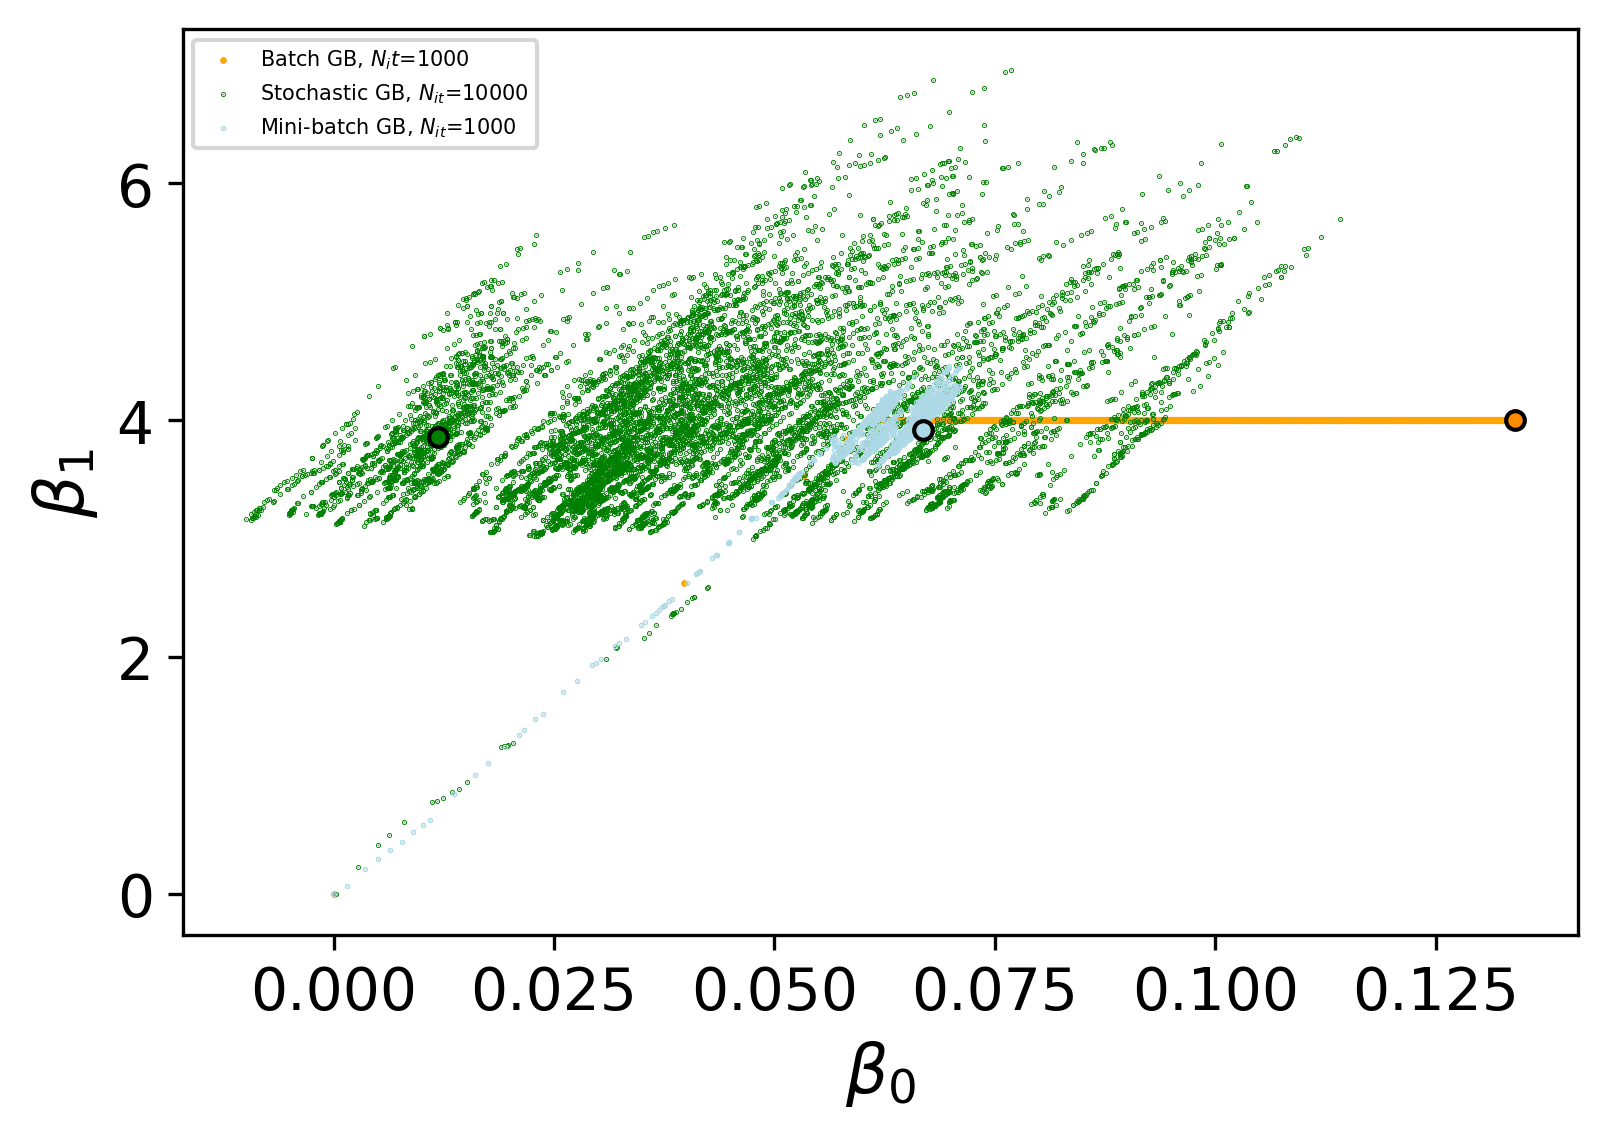

In [226]:
B = np.zeros(2)

batch_path = np.array(batch_GD(X, yp_wo, B, 0.0001, 1000))
stoch_path = np.array(stochastic_GD(X, yp_wo, B, 0.000005, 10000))
mini_path = np.array(mini_batch_GD(X, yp_wo, B, 0.000005, 1000, 10)) 

final_batch_path = batch_path[-1]
final_stoch_path = stoch_path[-1]
final_mini_path = mini_path[-1]


plt.scatter(batch_path[:,0],batch_path[:,1], s=0.5, marker='x',color='orange', label="Batch GB, $N_it$=1000 ")

plt.scatter(stoch_path[:,0],stoch_path[:,1], s=0.05,color='green', label="Stochastic GB, $N_{it}$=10000")

plt.scatter(mini_path[:,0],mini_path[:,1], s=0.1, color='lightblue', label="Mini-batch GB, $N_{it}$=1000")

plt.scatter(final_batch_path[0], final_batch_path[1], edgecolor='black',s=20, color='darkorange')
plt.scatter(final_stoch_path[0], final_stoch_path[1], edgecolor='black',color='green',s=20)
plt.scatter(final_mini_path[0], final_mini_path[1], edgecolor='black',color='lightblue', s=20)

plt.ylabel(r'$\beta_1$')
plt.xlabel(r'$\beta_0$')
plt.legend(fontsize=5)
plt.show()

### Step 6: 

For each of the three algorithms, try out a smaller and a larger learning rate than the values suggested. Try changing them by an order of magnitude and check out the effects in a plot of the same type in as in step 5. Would an adaptive learning rate be a solution? Qualitatively, how would you choose it?

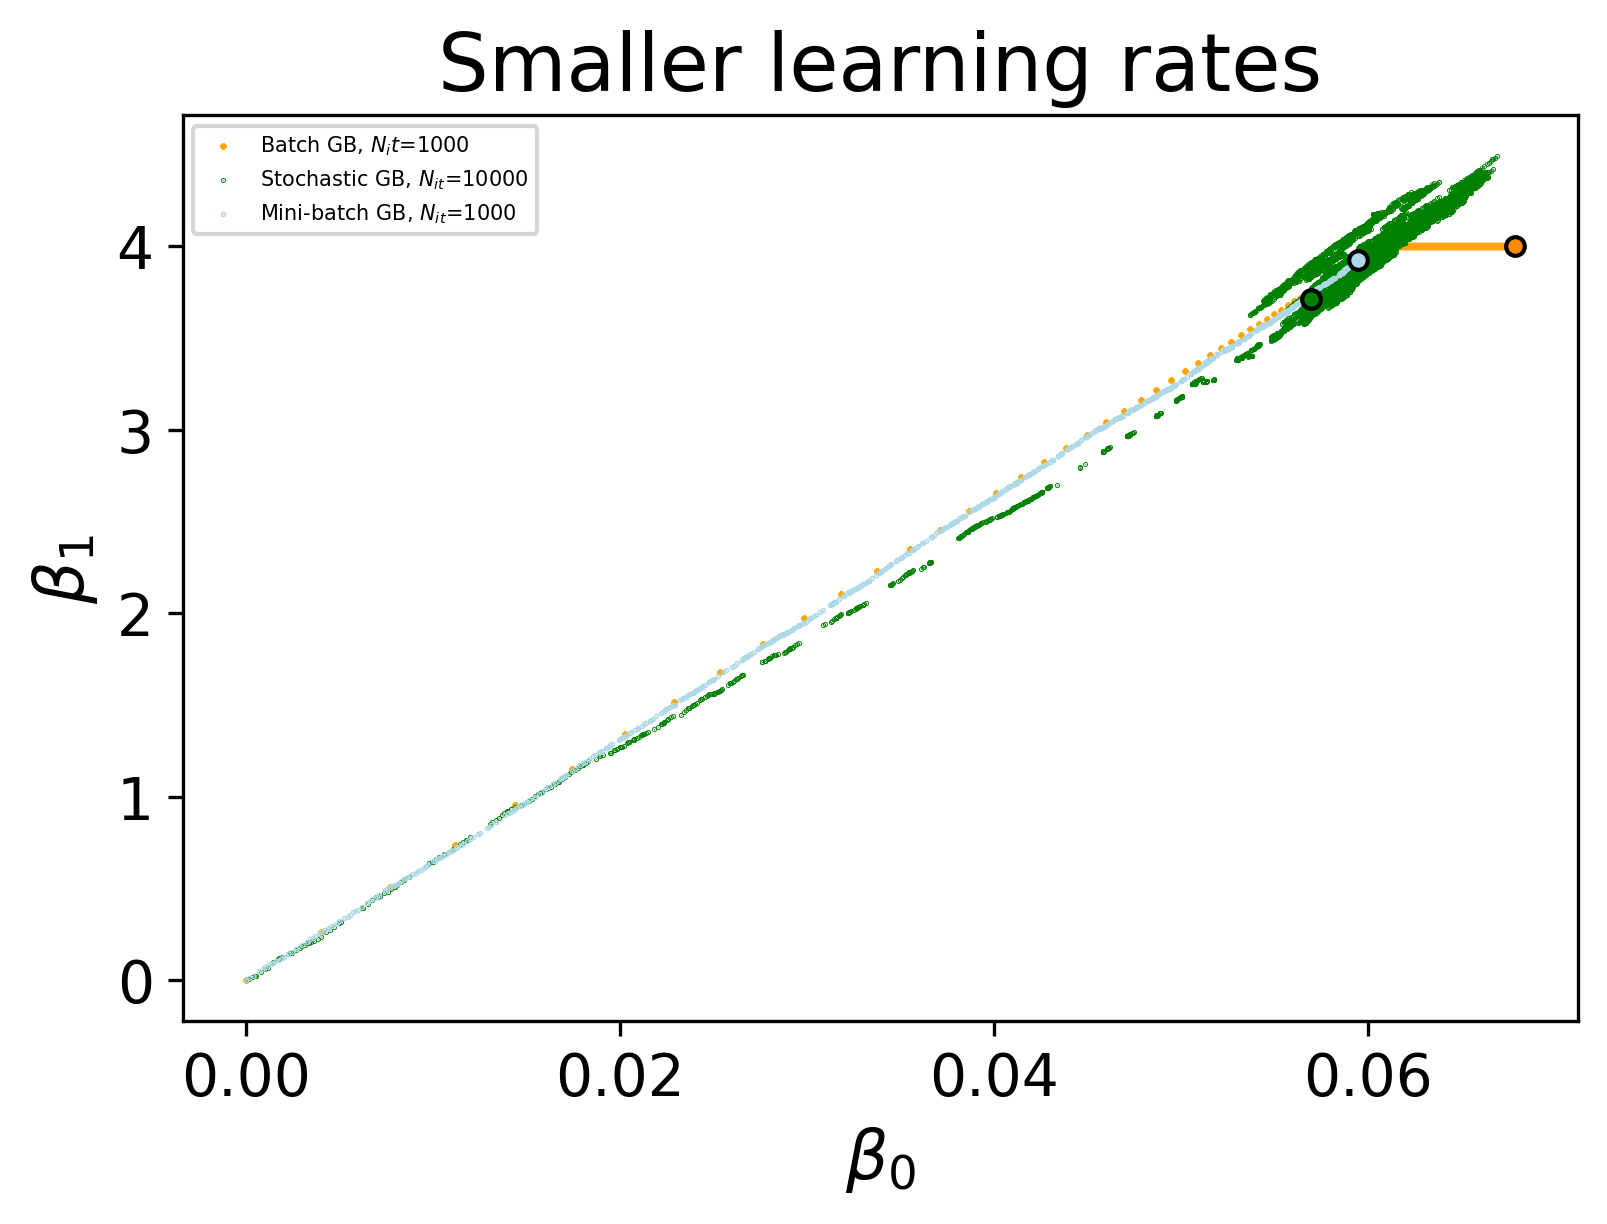

In [227]:
B = np.zeros(2)

batch_path = np.array(batch_GD(X, yp_wo, B, 0.0001/10, 1000))
stoch_path = np.array(stochastic_GD(X, yp_wo, B, 0.000005/10, 10000))
mini_path = np.array(mini_batch_GD(X, yp_wo, B, 0.000005/10, 1000, 10)) 

final_batch_path = batch_path[-1]
final_stoch_path = stoch_path[-1]
final_mini_path = mini_path[-1]

plt.scatter(batch_path[:,0],batch_path[:,1], s=0.5, marker='x',color='orange', label="Batch GB, $N_it$=1000 ")

plt.scatter(stoch_path[:,0],stoch_path[:,1], s=0.05,color='green', label="Stochastic GB, $N_{it}$=10000")

plt.scatter(mini_path[:,0],mini_path[:,1], s=0.1, color='lightblue', label="Mini-batch GB, $N_{it}$=1000")

plt.scatter(final_batch_path[0], final_batch_path[1], edgecolor='black',s=20, color='darkorange')
plt.scatter(final_stoch_path[0], final_stoch_path[1], edgecolor='black',color='green',s=20)
plt.scatter(final_mini_path[0], final_mini_path[1], edgecolor='black',color='lightblue', s=20)

plt.ylabel(r'$\beta_1$')
plt.xlabel(r'$\beta_0$')
plt.title("Smaller learning rates")
plt.legend(fontsize=5)
plt.show()

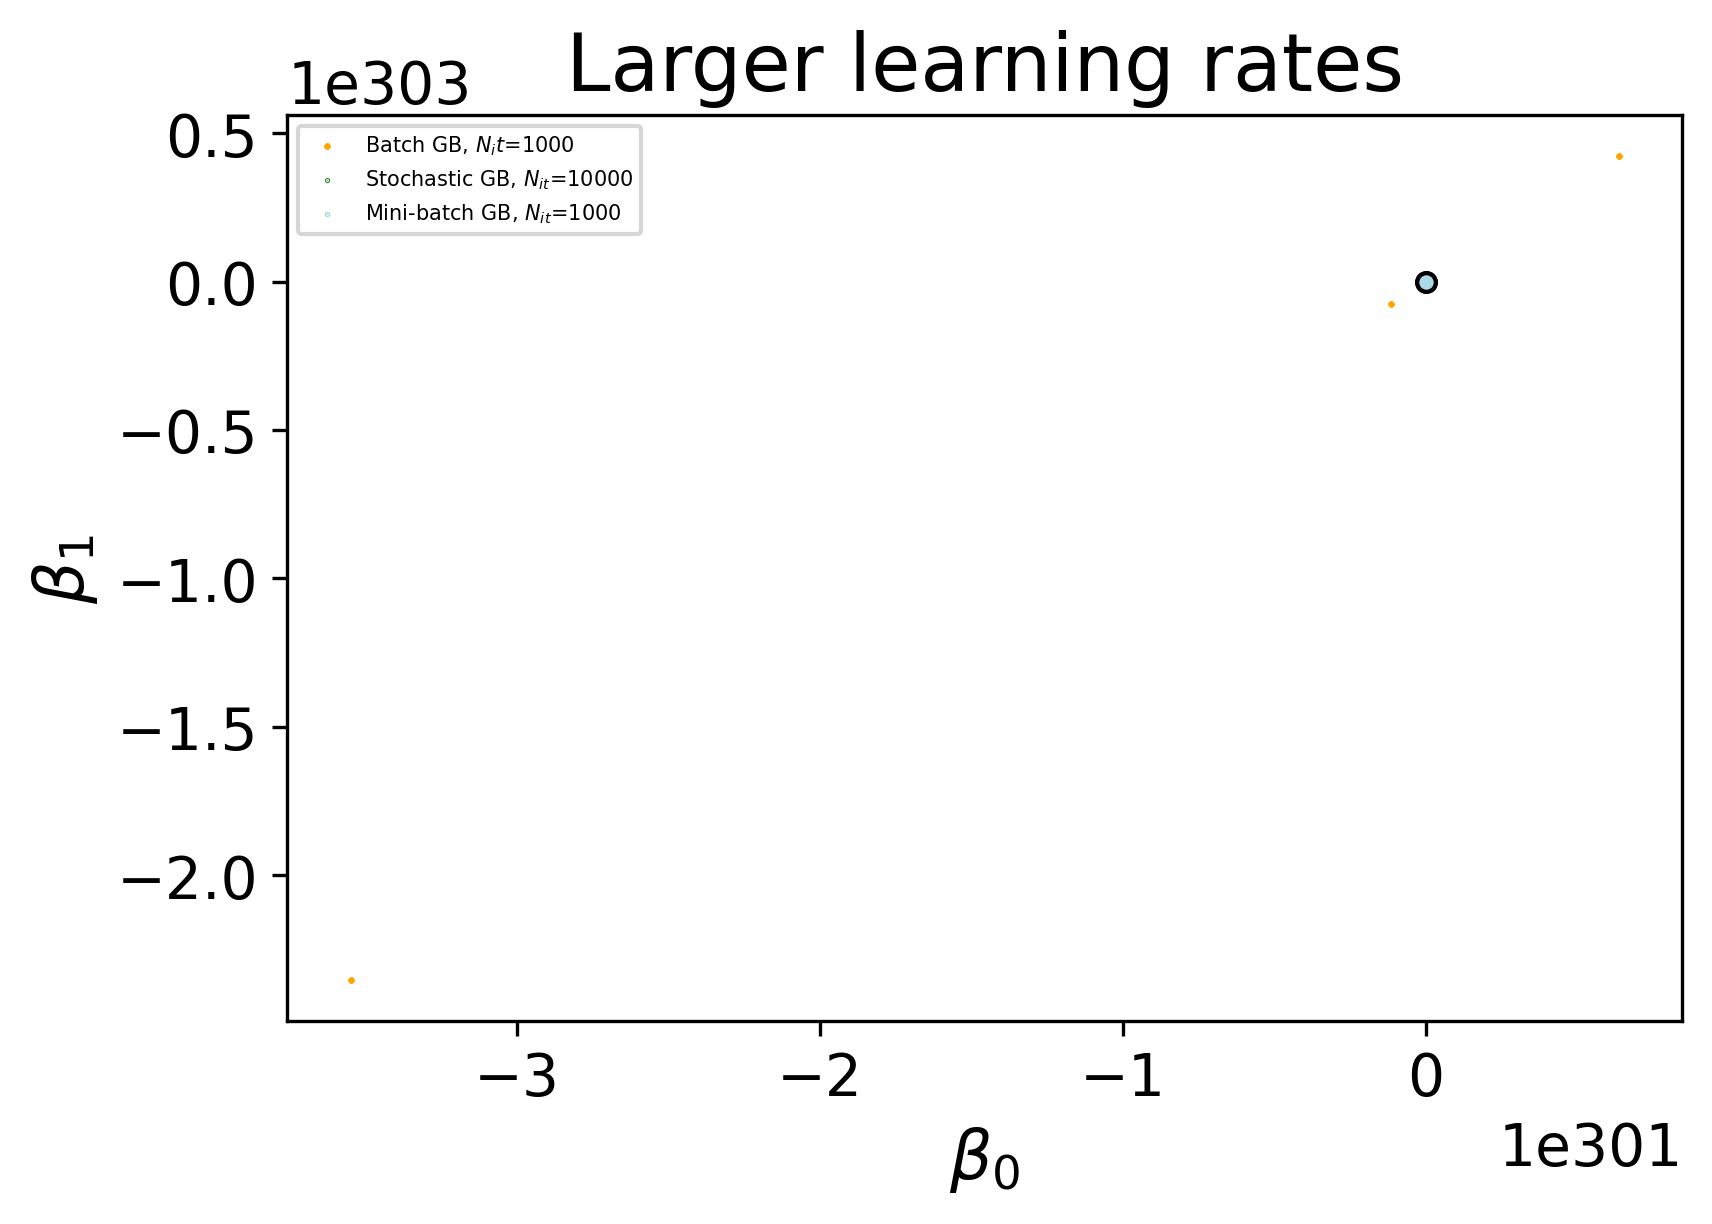

In [228]:
B = np.zeros(2)

batch_path = np.array(batch_GD(X, yp_wo, B, 0.0001*10, 1000))
stoch_path = np.array(stochastic_GD(X, yp_wo, B, 0.000005*10, 10000))
mini_path = np.array(mini_batch_GD(X, yp_wo, B, 0.000005*10, 1000, 10)) 

final_batch_path = batch_path[-1]
final_stoch_path = stoch_path[-1]
final_mini_path = mini_path[-1]

plt.scatter(batch_path[:,0],batch_path[:,1], s=0.5, marker='x',color='orange', label="Batch GB, $N_it$=1000 ")

plt.scatter(stoch_path[:,0],stoch_path[:,1], s=0.05,color='green', label="Stochastic GB, $N_{it}$=10000")

plt.scatter(mini_path[:,0],mini_path[:,1], s=0.1, color='lightblue', label="Mini-batch GB, $N_{it}$=1000")

plt.scatter(final_batch_path[0], final_batch_path[1], edgecolor='black',s=20, color='darkorange')
plt.scatter(final_stoch_path[0], final_stoch_path[1], edgecolor='black',color='green',s=20)
plt.scatter(final_mini_path[0], final_mini_path[1], edgecolor='black',color='lightblue', s=20)

plt.ylabel(r'$\beta_1$')
plt.xlabel(r'$\beta_0$')
plt.title("Larger learning rates")
plt.legend(fontsize=5)
plt.show()

Would an adaptive learning rate be a solution? Qualitatively, how would you choose it?
**An adaptive learning rate could be a solution, however to be completely thorough it would make sense to use a grid search, this would be quite taxing though and would take long to run. Additionally for values too large it blows up so we would need to use small step sizes. You would choose it when the final dots are the closest aligned**